Permutation Tests For NCI-MATCH Basket Trials
===
Created 6/30/2021 by Ivvone Zhou 

Reviewed and edited on 07/12/2021 by Deborah Plana

---

1. Common Functions 

2. Overview of Data

3. Tumor Volume Change

4. Progression-Free Survival

5. Benjamini-Hochberg Procedure (TODO)

5. Information on Source Data

## 1. Common Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Names of drugs tested and corresponding NCI MATCH subprotocols
# Ambiguity in Copanlisib trial: one point unknown cancer type, but narrowed down to GI or Gyn
info = [["Dabrafenib&Trametinib", "H"],
       ["T-DM1", "Q"],
       ["Trametinib","R"],
       ["Nivolumab", "Z1D"],
       ["AZD4547", "W"],
       ["Capivasertib", "Y"],
       ["Binimetinib", "Z1A"],
       ["Taselisib", "I"],
       ["CopanlisibGI", "Z1F"],
       ["CopanlisibGyn", "Z1F"],
       ["Afatinib", "B"],
       ["CopanlisibBlank", "Z1F"]]

In [3]:
def count_types(df, by, mode="Percent change"):
    """Returns # in each subtype, in descending order
    
    df = DataFrame containing the column of subtypes
    by = name of column containing subtypes
    mode = the values measured"""
    typecount = df.groupby(by=by).agg('count')
    typecount.sort_values(by=[mode], inplace=True, ascending=False)
    typecount = typecount[mode]
    return typecount

In [4]:
def p_calc(subtype_avg, x):
    """Returns left, right p-values
    
    subtype average= mean tumor volume change for that cancer type
    x= list of observations in null distribution (average tumor volume change for every iteration of simulation)"""
    left = sum(x <= subtype_avg) / len(x) #corresponds to test for superior tumor shrinkage
    right = sum(x >= subtype_avg) / len(x)  #corresponds to test for inferior tumor shrinkage
    return left, right

## 3. Overview of Data

Let's see how many patients are in each subgroup, both in tumor volume change and progression-free survival data. The distributions should be the same (imputed) for TVC and PFS if PFS was collected from only patients who had SD or better.

In [6]:
for i in range(12):
    num = i+1
    fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_tumorchange.xlsx"
    print(fileloc)
    df = pd.read_excel(fileloc)

    if num == 4 or num == 6:
        aggby = "Cancer category"
    else:
        aggby = "Cancer type"
    typecount = count_types(df, by=aggby)
    values = df.iloc[:,-1]
    print(typecount)

./1_Dabrafenib&Trametinib_H/1_H_tumorchange.xlsx
Cancer type
GYN                          6
Adeno lung                   4
Intra cholangio              4
CNS                          3
Mixed neuroendocrine ca      2
Adeno anus                   1
Adeno pancreas               1
Ameloblastoma of mandible    1
Neuroendocrine colon ca      1
Name: Percent change, dtype: int64
./2_T-DM1_Q/2_Q_tumorchange.xlsx
Cancer type
GYN                                             11
Lower GI                                         8
Biliary Adenocarcinoma                           3
Lung Carcinoma                                   3
Salivary Gland                                   2
Adenoca from Extramammary Paget's of Scrotum     1
Name: Percent change, dtype: int64
./3_Trametinib_R/3_R_tumorchange.xlsx
Cancer type
Lung                    7
GI                      5
Prostate                4
Gyn                     3
Other                   2
Breast                  1
Unknown primary site    1
Name: P

## 3. Tumor Volume Change

In [6]:
def sample(typecount, values, it=1000):
    """Returns df of subtype sampling (n>2)
    
    values = all tumor volume changes in a trial 
    typecount = number of patient for subgroup of interest 
    it = number of simulations to construct null hypothesis""" 
    names = typecount.index
    df_tosave = pd.DataFrame(columns=names)
    
    for i in range(len(typecount)):
        n = typecount[i]
        if n < 3 or names[i] == "Other":
            continue
        x = [np.average(values.sample(int(n))) for j in range(it)]
        df_tosave[names[i]] = x
    return df_tosave

First, we created a null distribution for each subtype with 3 or more participants. We drew 10^7 samples of n participants, n being the number of participants with the subtype of interest. We did this for each of the seven trials. This took several hours.

### Sample TVC via slurm (preferred):

Modify the line in`submit_sample_job.sh` which reads 
`python3 permutation_test_forcluster_tvc.py 8 7 3 tvc` to the run. `8` refers to the `8+1`th trial (`CopanlisibGII`), `7` refers to sampling `10**7` times, `3` refers to the 3rd time this is run, and `tvc` refers to sampling TVC (as opposed to PFS).

Then, run `sbatch submit_sample_job.sh`. 

For speed, run the file multiple times (changing the last iteration number), splitting up the sampling iterations. For example, to sample a total of $10^6$ times, you can run the code to sample $10^5$ times a total of 10 times, then aggregate them all using a line like 
`awk '(NR == 1) || (FNR > 1)' *pfs.xlsx.sampled_it*.csv > 4_Z1D_pfs.xlsx.sampled_full.csv`, modified to fit the trial.

In [7]:
# Sampling tumor change volume: time-consuming
for i in range(0):
    num = i+1
    fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_tumorchange.xlsx"
    print(fileloc)
    df = pd.read_excel(fileloc)
    
    n_it = 10**3
    
    if num == 4 or num == 6:
        aggby = "Cancer category"
    else:
        aggby = "Cancer type"
        
    typecount = count_types(df, by=aggby)
    values = df.iloc[:,-1]
    print(typecount)
    sampled = sample(typecount, values, it=n_it)
    sampled.to_csv(fileloc + "." + aggby + ".sampled_1k.csv")

Then, we plotted the null distributions with the subtype average and calculated its p-value. 

In [9]:
def plot(num, samplefileloc, typecount, values, aggby):
    """Plots and saves a plot containing all subtypes (n>2)
    num = trial #
    samplefileloc = path to csv of sampled values
    typecount = df of each subtype and # of patients with that subtype
    values = list of values for all subtypes"""
    title = str(num) + " - " + info[num-1][0] + " - " + str(info[num-1][1])
    print("Plotting " + title + "...")
    
    p_vals = []
    
    df_toplot = pd.read_csv(samplefileloc)
    overall_avg = np.average(values)

    x_min = -80
    x_max = 40

    fig, ax = plt.subplots(figsize=(2,8))
    # Formatting
    plt.rc('font', size=9)          # controls default text sizes
    plt.rc('axes', titlesize=9)     # fontsize of the axes title
    plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
    
    ymax = 0
    names = typecount.index
    n_subgroup = 0
    for i in range(len(typecount)):
        n = typecount[i]
        name = names[i]
        if n < 3 or name == "Other":
            continue
        subtype_avg = np.average(df[df[aggby] == name].iloc[:,-1])
        x = df_toplot[name]
        ps = p_calc(subtype_avg, x)
        p_vals.append([title+": "+name, ps[0], ps[1]])
        p = round(ps[0], 4)
        # first p-value (for values left of the observed mean, corresponding to null hypothesis of activity greater than expected)
        
        mpl.rcParams['axes.spines.left'] = False
        mpl.rcParams['axes.spines.right'] = False
        mpl.rcParams['axes.spines.top'] = False
        
        # BEGIN PLOT
        plt.subplot(9,1, n_subgroup+1)
        n_subgroup += 1
         
        # add average tvc to output
        plt.xlabel(name + " (n=" + str(n) + ")", wrap=True) # + " (n=" + str(n) + ", p=" + str(p) + ", average = " + str(round(subtype_avg,3))+ ")", wrap=True)
        
        ticks = np.arange(x_min, x_max+1, 40)
        plt.xticks(ticks=ticks)

        # Plot null distribution
        plt.hist(x, bins=35, density=True, color="silver")
        
        # Set ymax to be be max of first graph
        if i == 0:
            ymax = plt.gca().get_ylim()[1]
            
        plt.xlim(x_min, x_max)
        plt.ylim(0, ymax)
        
        plt.tick_params(left = False, labelleft = False)
        # Red line at subtype average
        plt.vlines(subtype_avg, ymin=0, ymax=ymax,color="crimson")
        
        i+=1
    
    # Title
    fig.suptitle(title)
    
    # Spacing between plots
    #plt.tight_layout()
    
    # Save
    plt.savefig(samplefileloc + "." + aggby + ".plot.pdf")
    plt.show()
    return p_vals

In [ ]:
# Plotting tumor change volume
for i in range(11,12):
    num = i+1
    fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_tumorchange.xlsx"
    print(fileloc)
    df = pd.read_excel(fileloc)
    
    if num == 4 or num == 6:
        aggby = "Cancer category"
    else:
        aggby = "Cancer type"
        
    typecount = count_types(df, by=aggby)
    values = df["Percent change"]
    p_vals = plot(num, fileloc+".sampled_full.csv", typecount, values, aggby)

./12_CopanlisibBlank_Z1F/12_Z1F_tumorchange.xlsx
Plotting 12 - CopanlisibBlank - Z1F...


## 3. Progression-Free Survival

[lifelines documentation](https://lifelines.readthedocs.io/en/latest/Quickstart.html)

In [7]:
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
import random
import math

In [5]:
def sample_pfs(typecount, values, it=1000):
    names = typecount.index
    df_tosave = pd.DataFrame(columns=names)
    
    for i in range(len(typecount)):
        n = typecount[i]
        if n < 3:
            continue
        x = [calc_hazard_ratio(values, values.shape[0], n) for j in range(it)]
        df_tosave[names[i]] = x
    return df_tosave

def calc_hazard_ratio(df, length, n):
    # Process df for analysis
    new_df = df
    subset_col = [0] * length + [1] * n
    new_df = new_df.append(new_df.sample(n))
    new_df["Subset"] = subset_col
    new_df = new_df[["Months", "Censoring value", "Subset"]]
    
    # Fit
    cph = CoxPHFitter()
    cph.fit(new_df, duration_col="Months", event_col="Censoring value")
    
    # Hazard ratio
    ratio = cph.hazard_ratios_["Subset"]
    print(cph.confidence_intervals_)
    cph.plot()
    
    return ratio

In [9]:
# sample pfs
for i in range(0):
    num = i+1
    fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_pfs.xlsx"
    print(fileloc)
    df = pd.read_excel(fileloc)
    
    n_it = 10
    
    if num == 4 or num == 6:
        aggby = "Cancer category"
    else:
        aggby = "Cancer type"
        
    typecount = count_types(df, by=aggby, mode="Months")
    values = df.iloc[:,-2:]
    print(typecount)

    sampled = sample_pfs(typecount, values, it=10)
    sampled.to_csv(fileloc + ".sampled_10.csv")

### Sample PFS via slurm (preferred):

Modify the line in`submit_sample_job.sh` which reads 
`python3 permutation_test_forcluster_tvc.py 8 5 3 pfs` to the run. `8` refers to the `8+1`th trial (`CopanlisibGI`), `5` refers to sampling `10**5` times, `3` refers to the 3rd time this is run, and `pfs` refers to sampling TVC (as opposed to TVC).

Then, run `sbatch submit_sample_job.sh`. 

For speed, run the file multiple times (changing the last iteration number), splitting up the sampling iterations. For example, to sample a total of $10^6$ times, you can run the code to sample $10^5$ times a total of 10 times, then aggregate them all using a line like 
`awk '(NR == 1) || (FNR > 1)' *pfs.xlsx.sampled_it*.csv > 4_Z1D_pfs.xlsx.sampled_full.csv`, modified to fit the trial.

In [6]:
def plot_log(ticks, base):
    # Converted wanted tick marks to log
    conv_ticks = []
    for t in ticks:
        # Ex: 1 base 2 -> 0
        # Ex: 1.5 base 2 -> 0.5850
        conv_ticks.append(math.log(t, base))
    return conv_ticks

In [10]:
def plot_pfs(num, samplefileloc, typecount, subtype_ratios, aggby):
    """Plots and saves a plot of pfs containing all subtypes (n>2) for a trial
    Returns left p-values
    
    num  = trial #
    samplefileloc = path to csv of sampled values
    typecount = df of each subtype and # of patients with that subtype
    values = list of values for all subtypes
    aggby = category of subtypes"""
    
    title = str(num) + " - " + info[num-1][0] + " - " + str(info[num-1][1])
    print("Plotting " + title + "...")
    
    p_vals = []

    ###
    df_toplot = pd.read_csv(samplefileloc)
    df_toplot.replace(10**-20, 10**20)
    
    x_max = df_toplot.max()[1:].max()
    x_min = df_toplot.min()[1:].min()
    print(x_max, x_min)
    names = typecount.index
    
    # Formatting
    fig, ax = plt.subplots(figsize=(2,8))
    plt.rc('font', size=9)          # controls default text sizes
    plt.rc('axes', titlesize=9)     # fontsize of the axes title
    plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
    
    fig.suptitle(title)
    
    for i in range(len(typecount)):
        n = typecount[i]
        if n < 3:
            continue
            
        name = names[i]
        # Not quite a subtype avg
        subtype_avg = subtype_ratios[i]
        x = df_toplot[name]
        
        ps = p_calc(subtype_avg, x)
        p = round(ps[0], 4)
        p_vals.append([title+": "+name, ps[0], ps[1]])
        
        mpl.rcParams['axes.spines.left'] = False
        mpl.rcParams['axes.spines.right'] = False
        mpl.rcParams['axes.spines.top'] = False
        
        # Begin plotting
        plt.subplot(7,1, i+1)
        plt.xlabel(name)# + " (n=" + str(n) + ", p=" + str(p) + ", ratio=" + str(round(subtype_avg,3))+ ")", wrap=True)
        
        x_ticks = [0.25, 1, 2, 4]
        plt.xticks(ticks=np.log2(x_ticks), labels=x_ticks)

        n_bins=35
        x_bins = np.arange(-2, 2, 0.1)

        plt.hist(np.log2(x), bins=x_bins, color="silver")

        plt.xlim(-2, 2)
        # Set ymax to be be max of first graph
        if i == 0:
            y_max = plt.gca().get_ylim()[1] 
        # Red line
        plt.vlines(np.log2(subtype_avg), ymin=0, ymax=y_max,color="crimson")
            
        plt.tick_params(left = False, labelleft = False)
        i+=1
        
    plt.tight_layout()
    plt.savefig(samplefileloc + "." + aggby + ".plot.pdf")
    plt.show()
    return p_vals

In [12]:
# Plotting pfs
for i in range(0):
    if i == 7:
        continue
    num = i+1
    fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_pfs.xlsx"
    print(fileloc)
    df = pd.read_excel(fileloc)
    
    if num == 4 or num == 6:
        aggby = "Cancer category"
    else:
        aggby = "Cancer type"

    typecount = count_types(df, by=aggby, mode="Months")
    
    subtype_ratios = []
    
    for j in range(len(typecount)):
        length = len(df)
        n = sum(df[aggby] == typecount.index[j])
        if n < 3:
            continue

        new_df = df
        subset_col = [0] * length + [1] * n
        new_df = new_df.append(new_df[df[aggby] == typecount.index[j]])
        new_df["Subset"] = subset_col
        new_df = new_df[["Months", "Censoring value", "Subset"]]
        
        # Analyze
        cph = CoxPHFitter()
        cph.fit(new_df, duration_col="Months", event_col="Censoring value")
        ratio = cph.hazard_ratios_["Subset"]
        #print(cph.confidence_intervals_)
        subtype_ratios.append(ratio)
    print(subtype_ratios)
    
    plot_pfs(num, fileloc+".sampled_full.csv", typecount, subtype_ratios, aggby)


## Benjamini-Hochberg Procedure

### Summary Plot(s)

In [20]:
run = True
# Saves all summary information in csv
df_tosave = pd.DataFrame(columns=["trial_num", "drug", "arm_id", "subgroup", "tvc_n", "tvc", "tvc_p", "pfs_n", "pfs", "pfs_p"])
for i in [0,1,2,3,4,5,6,7,10,11]:
    if not run:
        break
    num = i+1
    
    if num == 4 or num == 6:
        aggby = "Cancer category"
    else:
        aggby = "Cancer type"
    
    # PFS files
    if num != 8:
        pfs_fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_pfs.xlsx"
        pfs_df = pd.read_excel(pfs_fileloc)
        pfs_sampled_fileloc = pfs_fileloc + ".sampled_full.csv"
        pfs_sampled_df = pd.read_csv(pfs_sampled_fileloc)
        print(pfs_fileloc)
    
    # TVC files
    tvc_fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_tumorchange.xlsx"
    tvc_df = pd.read_excel(tvc_fileloc)
    tvc_sampled_fileloc = tvc_fileloc + ".sampled_full.csv"
    tvc_sampled_df = pd.read_csv(tvc_sampled_fileloc)
    print(tvc_fileloc)

    typecount = count_types(tvc_df, by=aggby, mode="Percent change")
    
    trial_avg = np.mean(tvc_df.iloc[:,-1])

    # For each subgroup
    for j in range(len(typecount)):
        ### PFS
        name = typecount.index[j]
        
        p_pfs = ratio = n_pfs = 0
        if num != 8:
            n_pfs = sum(pfs_df[aggby] == name)
            if n_pfs < 3:
                continue

            new_df = pfs_df
            subset_col = [0] * len(pfs_df) + [1] * n_pfs
            new_df = new_df.append(new_df[new_df[aggby] == name])
            new_df["Subset"] = subset_col
            new_df = new_df[["Months", "Censoring value", "Subset"]]

            # Analyze
            cph = CoxPHFitter()
            cph.fit(new_df, duration_col="Months", event_col="Censoring value")
            ratio = cph.hazard_ratios_["Subset"]

            p_pfs = round(p_calc(ratio, pfs_sampled_df[name])[0], 4)
        
        ### TVC
        n_tvc = sum(tvc_df[aggby] == name)
        if n_tvc < 3 or n_pfs < 3:
            continue
        subtype_avg = np.average(tvc_df[tvc_df[aggby] == name].iloc[:,-1])
        p_tvc = round(p_calc(subtype_avg, tvc_sampled_df[name])[0], 4)
        
        ### Putting it together
        row = pd.DataFrame({"trial_num": [num], 
                            "drug": [info[i][0]], 
                            "arm_id": [info[i][1]], 
                            "subgroup": [name], 
                            "tvc_n": [n_tvc], 
                            "tvc": [subtype_avg], 
                            "adj_tvc": [subtype_avg - trial_avg], 
                            "tvc_p": [p_tvc], 
                            "pfs_n": [n_pfs], 
                            "pfs": [ratio], 
                            "pfs_p": [p_pfs]})
        df_tosave = df_tosave.append(row, ignore_index = True)
        
df_tosave.to_csv("trial_results_summary_2.11_raw.csv")
df_tosave

./1_Dabrafenib&Trametinib_H/1_H_pfs.xlsx
./1_Dabrafenib&Trametinib_H/1_H_tumorchange.xlsx
./2_T-DM1_Q/2_Q_pfs.xlsx
./2_T-DM1_Q/2_Q_tumorchange.xlsx
./3_Trametinib_R/3_R_pfs.xlsx
./3_Trametinib_R/3_R_tumorchange.xlsx
./4_Nivolumab_Z1D/4_Z1D_pfs.xlsx
./4_Nivolumab_Z1D/4_Z1D_tumorchange.xlsx
./5_AZD4547_W/5_W_pfs.xlsx
./5_AZD4547_W/5_W_tumorchange.xlsx
./6_Capivasertib_Y/6_Y_pfs.xlsx
./6_Capivasertib_Y/6_Y_tumorchange.xlsx
./7_Binimetinib_Z1A/7_Z1A_pfs.xlsx
./7_Binimetinib_Z1A/7_Z1A_tumorchange.xlsx
./8_Taselisib_I/8_I_tumorchange.xlsx
./11_Afatinib_B/11_B_pfs.xlsx
./11_Afatinib_B/11_B_tumorchange.xlsx
./12_CopanlisibBlank_Z1F/12_Z1F_pfs.xlsx
./12_CopanlisibBlank_Z1F/12_Z1F_tumorchange.xlsx


,trial_num,drug,arm_id,subgroup,tvc_n,tvc,tvc_p,pfs_n,pfs,pfs_p,adj_tvc
0,1,Dabrafenib&Trametinib,H,GYN,6,-52.288980,0.0358,6,0.502545,0.0561,-17.008129
1,1,Dabrafenib&Trametinib,H,Adeno lung,4,-13.495405,0.9527,5,0.988633,0.4620,21.785445
2,1,Dabrafenib&Trametinib,H,Intra cholangio,4,-60.306466,0.0160,4,0.775095,0.2952,-25.025615
3,1,Dabrafenib&Trametinib,H,CNS,3,-45.528488,0.2678,5,1.187728,0.6106,-10.247638
4,2,T-DM1,Q,GYN,11,9.989578,0.8290,11,1.056270,0.5566,13.840700
5,2,T-DM1,Q,Lower GI,8,3.192638,0.6649,8,1.440129,0.8395,7.043760
6,2,T-DM1,Q,Biliary Adenocarcinoma,3,-27.108344,0.2384,3,2.345554,0.8684,-23.257221
7,2,T-DM1,Q,Lung Carcinoma,3,21.301508,0.8108,3,2.214687,0.8588,25.152631
8,3,Trametinib,R,Lung,7,-21.743351,0.0263,9,0.903117,0.3286,-17.280719
9,3,Trametinib,R,GI,5,20.878986,0.9945,8,2.446292,0.9897,25.341618


In [26]:
# INCOMPLETE as of 8/26/22
def b_h(df, fdr=0.25):
    """
    Takes in a summary file generated from above code, 
    returns df with two columns indicating significance by Benjamini-hochberg procedure
    """
    # trial_num
    new_df = pd.DataFrame()
    tvc_sig = np.empty(0)
    pfs_sig = np.empty(0)
    for i in range(10):
        trial = df[df["trial_num"] == i]
        trial = trial[trial["subgroup"] != "Other"]
        
        # TVC
        trial = trial.sort_values(by='tvc_p')
        crit_vals = np.array(range(1, len(trial)+1)) / len(trial) * fdr
        trial["tvc_sig"] = (trial.loc[:,"tvc_p"] < crit_vals)*1
        tvc_sig = np.append(tvc_sig, trial["tvc_sig"])
        
        # PFS
        trial = trial.sort_values(by='pfs_p')
        trial["pfs_sig"] = (trial.loc[:,"pfs_p"] < crit_vals)*1
        pfs_sig = np.append(pfs_sig, trial["pfs_sig"])

        new_df = pd.concat([df,trial])
        
    #new_df["tvc_sig2"] = tvc_sig
    #new_df["pfs_sig2"] = pfs_sig
    print(tvc_sig, pfs_sig)
    #new_df["tvc_sig"] = tvc_sig
    #new_df["pfs_sig"] = pfs_sig
    print(new_df)
    return new_df

In [27]:
fileloc = "trial_results_summary.csv"
file = pd.read_csv(fileloc)
b_h(file)

[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
    Unnamed: 0  trial_num                   drug arm_id  \
0            0          1  Dabrafenib&Trametinib      H   
1            1          1  Dabrafenib&Trametinib      H   
2            2          1  Dabrafenib&Trametinib      H   
3            3          1  Dabrafenib&Trametinib      H   
4            4          2                  T-DM1      Q   
5            5          2                  T-DM1      Q   
6            6          2                  T-DM1      Q   
7            7          2                  T-DM1      Q   
8            8          3             Trametinib      R   
9            9          3             Trametinib      R   
10          10          3             Trametinib      R   
11          11          3             Trametinib      R   
12         

,Unnamed: 0,trial_num,drug,arm_id,subgroup,tvc_n,tvc,tvc_p,pfs_n,pfs,pfs_p,adj_tvc,tvc_sig,pfs_sig
0,0,1,Dabrafenib&Trametinib,H,GYN,6,-52.288980,0.0358,6,0.502545,0.0561,-17.008129,NaN,NaN
1,1,1,Dabrafenib&Trametinib,H,Adeno lung,4,-13.495405,0.9527,5,0.988633,0.4620,21.785445,NaN,NaN
2,2,1,Dabrafenib&Trametinib,H,Intra cholangio,4,-60.306466,0.0160,4,0.775095,0.2952,-25.025615,NaN,NaN
3,3,1,Dabrafenib&Trametinib,H,CNS,3,-45.528488,0.2678,5,1.187728,0.6106,-10.247638,NaN,NaN
4,4,2,T-DM1,Q,GYN,11,9.989578,0.8290,11,1.056270,0.5566,13.840700,NaN,NaN
5,5,2,T-DM1,Q,Lower GI,8,3.192638,0.6649,8,1.440129,0.8395,7.043760,NaN,NaN
6,6,2,T-DM1,Q,Biliary Adenocarcinoma,3,-27.108344,0.2384,3,2.345554,0.8684,-23.257221,NaN,NaN
7,7,2,T-DM1,Q,Lung Carcinoma,3,21.301508,0.8108,3,2.214687,0.8588,25.152631,NaN,NaN
8,8,3,Trametinib,R,Lung,7,-21.743351,0.0263,9,0.903117,0.3286,-17.280719,NaN,NaN
9,9,3,Trametinib,R,GI,5,20.878986,0.9945,8,2.446292,0.9897,25.341618,NaN,NaN


C:\Users\Ivvone Zhou\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Ivvone Zhou\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1 Dabrafenib&Trametinib GYN -35.28085066
2 Dabrafenib&Trametinib Intra cholangio -35.28085066
3 Trametinib Lung -4.46263197
4 AZD4547 Salivary gland -2.9697004639999998
5 AZD4547 Urothelial/bladder -2.9697004599999985
6 Capivasertib Gynecologic -34.166616073
7 Capivasertib Breast carcinoma -34.16661608
8 Binimetinib Head and neck tumor 6.580812079
9 Binimetinib Cholangiocarcinoma 6.580812085
10 Afatinib Breast ER+ 6.355355372


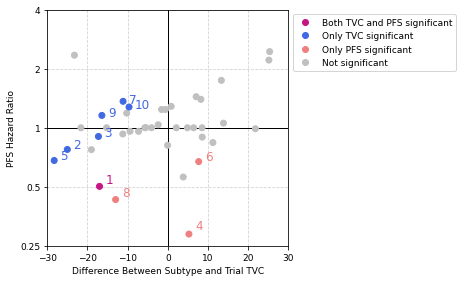

In [27]:
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle

df_summary = pd.read_excel("trial_results_summary_withsig_manual.xlsx")
df_summary["sig_or"] = df_summary["tvc_sig"] + 2* df_summary["pfs_sig"] 

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

# Formatting
plt.rc('font', size=9)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
    
fig, ax = plt.subplots(figsize=(6.5,4))

ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

df_summary["pfs"].iloc[df_summary["pfs"]==0] = 1

# colors
colors = df_summary["sig_or"]
colors.iloc[colors==0] = "silver"
colors.iloc[colors==1] = "royalblue" 
colors.iloc[colors==2] = "lightcoral"
colors.iloc[colors==3] = "mediumvioletred"
ax.scatter(df_summary["adj_tvc"], plot_log(df_summary["pfs"],2), c=colors, zorder=3) #, s=df_summary["tvc_n"]*10)

# Labels
count = 1
for index, row in df_summary.iterrows():
    if row["sig_or"] != "silver":
        plt.text(row["adj_tvc"]+1.5, np.log2(row["pfs"])*0.95, count, size=12, color=row["sig_or"])
        print(count, row["drug"], row["subgroup"], row["tvc"]-row["adj_tvc"])
        count += 1

ticks = [0.25, 0.5, 1, 2, 4]
log_ticks = plot_log(ticks, 2)
ax.set_yticks(log_ticks)
ax.set_yticklabels(ticks)

plt.xlim(-30,30)

both_patch = mlines.Line2D([], [], color='mediumvioletred', marker='.', linestyle='None',
                          markersize=12, label='Both TVC and PFS significant')
tvc_patch = mlines.Line2D([], [], color='royalblue', marker='.', linestyle='None',
                          markersize=12, label='Only TVC significant')
pfs_patch = mlines.Line2D([], [], color='lightcoral', marker='.', linestyle='None',
                          markersize=12, label='Only PFS significant')
none_patch = mlines.Line2D([], [], color='silver', marker='.', linestyle='None',
                          markersize=12, label='Not significant')
plt.legend(handles=[both_patch, tvc_patch, pfs_patch, none_patch], bbox_to_anchor=(1, 1, 0, 0), ncol=1)

plt.grid(b=True, which='major', color='lightgray', linestyle='--')

plt.xlabel("Difference Between Subtype and Trial TVC")
plt.ylabel("PFS Hazard Ratio")
plt.tight_layout()
plt.savefig("./zFigures/pfs_vs_tvc_2.11.pdf")
plt.show()

In [ ]:
i = 0
num = 1
fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_pfs.xlsx.sampled_full.csv"
print(fileloc)
df = pd.read_csv(fileloc)
df

In [ ]:
series = df.GYN
q1 = np.percentile(series,  5)
q2 = np.percentile(series,  50)
q3 = np.percentile(series,  95)
print(q1, q2, q3)

# For Plot

In [9]:
i=2
num = i+1
fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_tumorchange.xlsx"
print(fileloc)
df = pd.read_excel(fileloc)

./3_Trametinib_R/3_R_tumorchange.xlsx


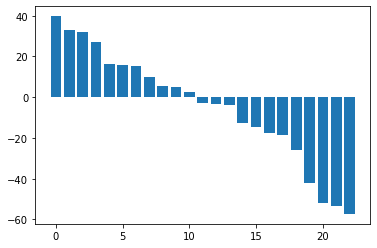

In [6]:
# waterfall plot
plt.bar(x=range(len(df.index)), height=df["Percent change"])
plt.savefig('./3.svg')

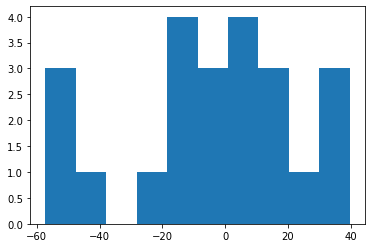

In [10]:
# histogram
plt.hist(df["Percent change"])
plt.savefig('./3hist1.svg')
plt.show()

In [10]:
# sampling 1
fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_tumorchange.xlsx.sampled_full.csv"
print(fileloc)
df_s = pd.read_csv(fileloc)

./3_Trametinib_R/3_R_tumorchange.xlsx.sampled_full.csv


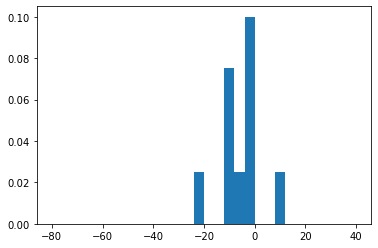

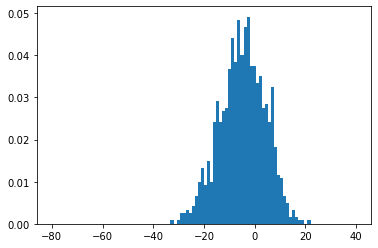

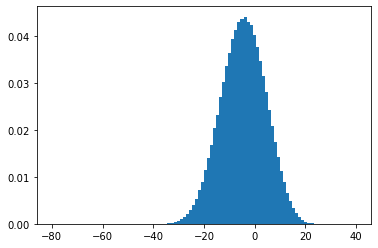

10000000

In [19]:
df_s.head(5)

plt.hist(df_s["Lung"][range(10)], bins=30, range=(-80, 40), density=True)

#df_s.columns
plt.savefig('./3sample10.svg')
plt.show()

plt.hist(df_s["Lung"][range(1000)], bins=100, range=(-80, 40), density=True)
plt.savefig('./3sample10_3.svg')
plt.show()

plt.hist(df_s["Lung"][range(10**7)], bins=100, range=(-80, 40), density=True)
plt.savefig('./3sample10_7.svg')
plt.show()

len(df_s.index)

In [11]:
p_vals = np.arange(0, 10**7, 100000, dtype="float")+100000
print(p_vals)
avg = np.average(df["Percent change"][df["Cancer type"]=="Lung"])

for i in range(100000, 10**7+100000, 100000):
    p_val = p_calc(avg, df_s["Lung"][range(i)])    
    p_vals[int(i/100000-1)] = p_val[0]

print(p_vals)

[  100000.   200000.   300000.   400000.   500000.   600000.   700000.
   800000.   900000.  1000000.  1100000.  1200000.  1300000.  1400000.
  1500000.  1600000.  1700000.  1800000.  1900000.  2000000.  2100000.
  2200000.  2300000.  2400000.  2500000.  2600000.  2700000.  2800000.
  2900000.  3000000.  3100000.  3200000.  3300000.  3400000.  3500000.
  3600000.  3700000.  3800000.  3900000.  4000000.  4100000.  4200000.
  4300000.  4400000.  4500000.  4600000.  4700000.  4800000.  4900000.
  5000000.  5100000.  5200000.  5300000.  5400000.  5500000.  5600000.
  5700000.  5800000.  5900000.  6000000.  6100000.  6200000.  6300000.
  6400000.  6500000.  6600000.  6700000.  6800000.  6900000.  7000000.
  7100000.  7200000.  7300000.  7400000.  7500000.  7600000.  7700000.
  7800000.  7900000.  8000000.  8100000.  8200000.  8300000.  8400000.
  8500000.  8600000.  8700000.  8800000.  8900000.  9000000.  9100000.
  9200000.  9300000.  9400000.  9500000.  9600000.  9700000.  9800000.
  9900

NameError: name 'p_vas' is not defined

AttributeError: This method only works with the ScalarFormatter

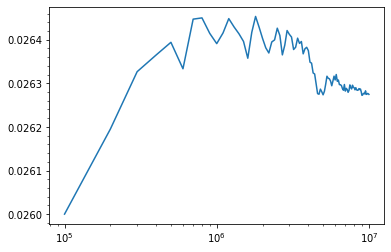

In [20]:
np.savetxt("pvals_trametinib_lung_by105.csv", p_vals, delimiter=",")


fig, ax = plt.subplots()    
ax.set_xscale('log')
plt.plot(np.arange(0, 10**7, 100000, dtype="float")+100000, p_vals)
plt.minorticks_on()

plt.ticklabel_format(style='scientific')
plt.title("Trametinib: Lung: P-value every 10^5 from 10^5 to 10^7")
plt.savefig('./3sampleby5.svg')

print(avg)

[0.0, 0.02, 0.034, 0.0247, 0.026, 0.026391, 0.0262746]


AttributeError: This method only works with the ScalarFormatter

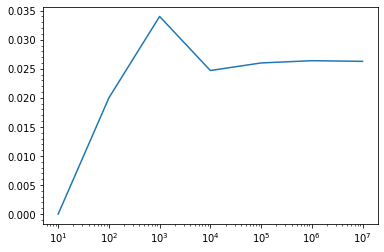

In [30]:
p_vals = [10, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7]
avg = np.average(df["Percent change"][df["Cancer type"]=="Lung"])

for i in range(1,8):
    p_val = p_calc(avg, df_s["Lung"][range(p_vals[i-1])])
    p_vals[i-1] = p_val[0]

print(p_vals)

fig, ax = plt.subplots()    
ax.set_xscale('log')
plt.plot([10, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7], p_vals)
plt.minorticks_on()

plt.ticklabel_format(style='scientific')
plt.title("Trametinib: Lung: P-value every 10^5 from 10^5 to 10^7")
#plt.savefig('./3sampleby5.svg')

print(avg)

./3_Trametinib_R/3_R_pfs.xlsx


,Cancer type,Months,Censoring value
30,Lung,0.428139,1
29,Unknown primary site,0.908753,1
22,GI,1.102748,1
31,GI,1.104771,1
27,Prostate,1.111013,1
20,GI,1.209866,1
21,Lung,1.316543,1
25,Gyn,1.366758,1
13,GI,1.650710,1
24,Lung,1.729146,1


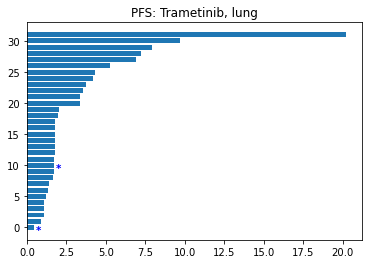

In [114]:
i=2
num = i+1
fileloc = "./" + str(num) + "_" + info[i][0] + "_" + info[i][1] + "/" + str(num) + "_" + info[i][1] + "_pfs.xlsx"
print(fileloc)
df = pd.read_excel(fileloc)
df = df.sort_values("Months")
# swimmer plot
fig, ax = plt.subplots()    
plt.barh(y=range(len(df.index)), width=df["Months"])

for i, v in enumerate(df["Months"]):
    if df["Censoring value"][i]==0:
        ax.text(v + 0.1, i-0.9, "*", color='blue', fontweight='bold')
        
plt.title("PFS: Trametinib, lung")
plt.savefig('./3pfs.svg')
df

## Information on Source Data
| Journal | Arm | Title and Citation | Lead Author |
| :----------- | :----------- | :----------- | :----------- |
| Annals of Oncology	| Q |	**Ado-trastuzumab emtansine (T-DM1)** in patients with HER2 amplified tumors excluding breast and gastric/gastro-esophageal junction (GEJ) adenocarcinomas: Results from the NCI-MATCH Trial (EAY131) Subprotocol Q Jhaveri KL. Ann Oncol. 2019 Nov 1;30(11):1821-1830 | Komal L. Jhaveri |
| Journal of Clinical Oncology | Z1D | **Nivolumab** Is Effective in Mismatch Repair–Deficient Noncolorectal Cancers: Results From Arm Z1D—A Subprotocol of the NCI-MATCH (EAY131) Study Azad NS. J Clin Oncol. 2019 Nov 25:JCO.1900818 | Nilofer S. Azad |
|Clinical Cancer Research|	R|	**Trametinib** activity in patients with solid tumors and lymphomas harboring BRAF non-V600 mutations or fusions: Results from NCI-MATCH (EAY131) Johnson DB. Clin Cancer Res. 2020 Jan 10 | Douglas B. Johnson |
|Journal of Clinical Oncology	|W|	Phase II Study of **AZD4547** in Patients With Tumors Harboring Aberrations in the FGFR Pathway: Results From the NCI-MATCH Trial (EAY131) Subprotocol W Chae YK. J Clin Oncol. 2020 May 28:JCO.19.02630 | Young K. Chae |
| Journal of Clinical Oncology|	H|	**Dabrafenib and Trametinib** in Patients With Tumors With BRAFV600E Mutations: Results of the NCI-MATCH Trial Subprotocol H Salama AKS. J Clin Oncol. 2020 Aug 06:JCO.20.00762 | April K.S. Salama|
|JAMA Oncology	|Y|	Effect of **Capivasertib** in Patients with an AKT1 E17K-mutated Tumor: NCI-MATCH Subprotocol EAY131-Y Nonrandomized Trial Kalinsky KM. JAMA Oncol. 2020 Dec 30 | Kevin M. Kalinsky|
| Clinical Cancer Research	|Z1A|	Differential Outcomes in Codon 12/13 and Codon 61 NRAS-Mutated Cancers in the Phase 2 NCI-MATCH Trial of **Binimetinib** in Patients with NRAS-Mutated Tumors Cleary JM. Clin Cancer Res. 2021 Feb 26|James M. Cleary|

End of file.